# Previous work

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import librosa
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, accuracy_score, confusion_matrix, precision_score, recall_score


# EDA

Using the dataset [GTZAN](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification), there is already a csv of features of music snippets, so we don't have to extract features manually(for now)

Given features:
- length
- chroma_stft_mean
- chroma_stft_var

chroma_stft - chromagram from a waveform or power spectrogram
- rms_mean
- rms_var

rms - root-mean-square (RMS) value for each frame, either from the audio samples or from a spectrogram

- spectral_centroid_mean
- spectral_centroid_var

spectral centroid - indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

- spectral_bandwidth_mean
- spectral_bandwidth_var

spectral bandwidth - the spectral range of interest around the centroid, that is, the variance from the spectral centroid.

- rolloff_mean
- rolloff_var

The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. 

- zero_crossing_rate_mean
- zero_crossing_rate_var

The zero crossing rate indicates the number of times that a signal crosses the horizontal axis.

- harmony_mean
- harmony_var

harmonic elements from an audio time-series.

- perceptr_mean
- perceptr_var


- tempo

- mfcc1..mfcc20_mean
- mfcc1..mfcc20_var

Mel-frequency cepstral coefficients

In [ ]:
data = pd.read_csv('features_30_sec.csv')
data = data.iloc[0:, 1:] 
data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
data.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,1.844345e+06,0.103612,0.002986,-3.659332e-04,0.012540,-0.000395,5.670073e-03,119.505363,-144.472987,3747.875414,99.554278,706.899539,-8.920291,468.286436,36.292447,220.447219,-1.144840,174.404462,14.633491,127.232071,-5.129038,116.367019,10.119172,88.198988,-6.994062,88.566933,7.729785,81.733490,-6.021069,75.551228,4.471693,68.670817,-4.795884,67.871712,1.781900,64.764096,-3.869308,62.873761,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,1.425085e+06,0.041821,0.003024,1.683946e-03,0.011653,0.001082,6.500325e-03,28.264176,100.229406,2770.558394,31.330873,439.120256,21.690676,287.143462,16.664665,116.236941,12.221340,100.767823,11.839591,68.475115,9.940460,58.400048,10.463270,41.048213,8.283921,39.494072,7.937309,36.733649,6.817013,38.135183,6.715787,32.625534,6.170181,33.154276,5.008385,34.450290,4.873599,33.904101,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,1.468612e+04,0.021697,0.000044,-2.606458e-02,0.000049,-0.007150,8.299008e-07,54.978391,-552.120056,174.571365,-1.461542,93.104752,-89.870193,35.467754,-18.727547,34.263149,-38.890347,29.912008,-28.415911,20.847921,-32.930431,29.027332,-24.915823,22.464230,-31.640574,25.825863,-12.050177,19.273201,-28.057501,21.402756,-15.796446,18.642517,-27.523129,17.293922,-12.594489,14.250607,-17.539125,9.769691,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,7.727312e+05,0.070244,0.001079,-1.041584e-04,0.004383,-0.000537,1.292592e-03,99.384014,-200.763893,1844.488129,76.779915,398.020767,-24.219811,270.466576,24.108212,129.397377,-9.979157,101.266209,5.098573,76.505194,-12.870810,73.546917,1.609181,57.349041,-13.246939,59.882313,1.620753,55.734016,-10.964135,51.242420,-0.547371,46.854038,-9.357906,46.294396,-1.639417,43.416593,-7.165884,42.236251,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,1.476115e+06,0.099503,0

In [ ]:
data3sec = pd.read_csv('features_3_sec.csv')
data3sec = data3sec.iloc[0:, 1:] 
data3sec.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,0.081851,0.000558,-0.000078,0.008354,-0.000068,0.005535,129.199219,-118.627914,2440.286621,125.083626,260.956909,-23.443724,364.081726,41.321484,181.694855,-5.976108,152.963135,20.115141,75.652298,-16.045410,40.227104,17.855198,84.320282,-14.633434,83.437233,10.270527,97.001335,-9.708279,66.669891,10.183875,45.103611,-4.681614,34.169498,8.417439,48.269444,-7.233477,42.770947,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,0.087173,0.001030,-0.000099,0.004950,-0.000103,0.004854,123.046875,-125.590706,2038.344238,122.421227,216.774185,-20.718019,231.979767,50.128387,142.700409,-11.333302,139.243118,21.385401,77.817947,-15.960796,97.364029,19.454103,57.948093,-12.465918,68.271523,17.898169,56.222176,-11.732554,54.373909,8.145000,40.662876,-7.717751,30.808521,8.397150,48.784225,-8.300493,68.584824,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,0.071383,0.000425,-0.000066,0.012476,0.000065,0.004357,123.046875,-132.441940,3798.532227,115.085175,257.321289,-14.811666,192.448074,50.189293,144.166031,-0.680819,128.376892,24.650375,66.371170,-13.506104,89.319336,15.643386,55.253967,-13.216637,120.308784,10.406025,35.757862,-7.991465,47.911613,11.853963,36.569931,-4.677677,40.725075,6.571110,30.686846,-2.424750,50.313499,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,9.216524e+05,0.069426,0.000304,-0.000014,0.008318,0.000018,0.005927,123.046875,-118.231087,2508.781006,132.116501,332.650574,-18.758335,109.357529,39.769306,184.693344,-13.260426,144.398224,20.468134,122.516464,-14.563448,68.937332,18.745104,74.748886,-13.755463,73.868576,12.993759,41.549564,-12.648887,58.540478,10.389314,39.102024,-4.362739,60.714748,9.156193,40.411537,-9.889441,44.666325,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,6.102111e+05,0.070095,0.000289,0.000041,0.009634,-0.000106,0.005833,123.046875,-105.968376,2118.919922,134.643646,219.562622,-19.961748,171.878754,40.171753,103.120712,-14.271939,102.651230,18.734617,79.070000,-15.619381,48.510284,19.207966,53.642956,-18.274683,95.300995,14.316693,58.821163,-5.792194,55.030254,17.045437,43.229939,-5.681399,46.515259,5.705521,24.956211,-7.986080,39.816933,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [ ]:
data3sec.describe()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.0,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,66149.0,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,1.628790e+06,0.102578,0.002620,-0.000365,1.259757e-02,-0.000396,5.601553e-03,124.887709,-145.424643,2808.904199,100.988234,588.795354,-9.995014,374.137619,37.243725,183.911272,-2.009099,143.817714,15.395436,107.784375,-5.823034,98.505164,10.766659,74.795022,-7.569825,74.309310,8.283669,68.803998,-6.504168,63.812684,4.936315,57.790413,-5.186272,57.130389,2.164629,54.069345,-4.175271,52.678281,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.0,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,1.489398e+06,0.045651,0.003614,0.001699,1.263324e-02,0.001108,6.653225e-03,32.911676,106.456350,2596.256821,34.673178,459.705227,23.972522,294.470578,17.804460,133.164251,13.568717,109.272584,12.652512,75.900398,11.088698,65.536682,11.123007,45.881275,9.368422,44.733012,8.841558,41.864203,7.821168,40.218357,7.563187,37.481013,7.132049,35.746539,6.084283,37.715592,5.929457,37.251966,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,1.145102e+03,0.013525,0.000005,-0.026672,9.312309e-23,-0.008794,4.672045e-08,24.377211,-662.171631,25.190538,-12.053392,9.665931,-104.249832,2.055229,-35.138493,3.540373,-47.886780,9.754141,-34.889263,5.267811,-45.187019,7.561506,-40.323467,6.899100,-39.451752,8.252314,-32.833546,7.584913,-40.008194,4.998892,-23.759195,2.345633,-29.350500,7.806118,-23.390091,3.230073,-30.467087,1.481917,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,66149.0,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,5.595514e+05,0.067290,0.000628,-0.000127,4.086402e-03,-0.000579,1.106077e-03,103.359375,-201.474651,1143.226685,76.043871,270.420326,-26.884581,174.570415,24.450934,88.392767,-11.881086,67.975819,5.759286,53.944843,-14.464527,51.585960,2.528776,42.255037,-14.569940,42.856218,1.734222,40.205816,-12.203228,37.617884,-0.433691,34.455327,-10.352716,34.844897,-1.860355,32.415298,-8.184258,31.237773,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,66149.0,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,1.160080e+06,0.097868,0.001390,-0.000013,8.429785e-03

In [ ]:
# import sys 
# !{sys.executable} -m pip install -U pandas-profiling[notebook]
# !jupyter nbextension enable --py widgetsnbextension
# import pandas_profiling
# from pandas_profiling.utils.cache import cache_file

# profile = pandas_profiling.ProfileReport(data)
# profile.to_notebook_iframe()

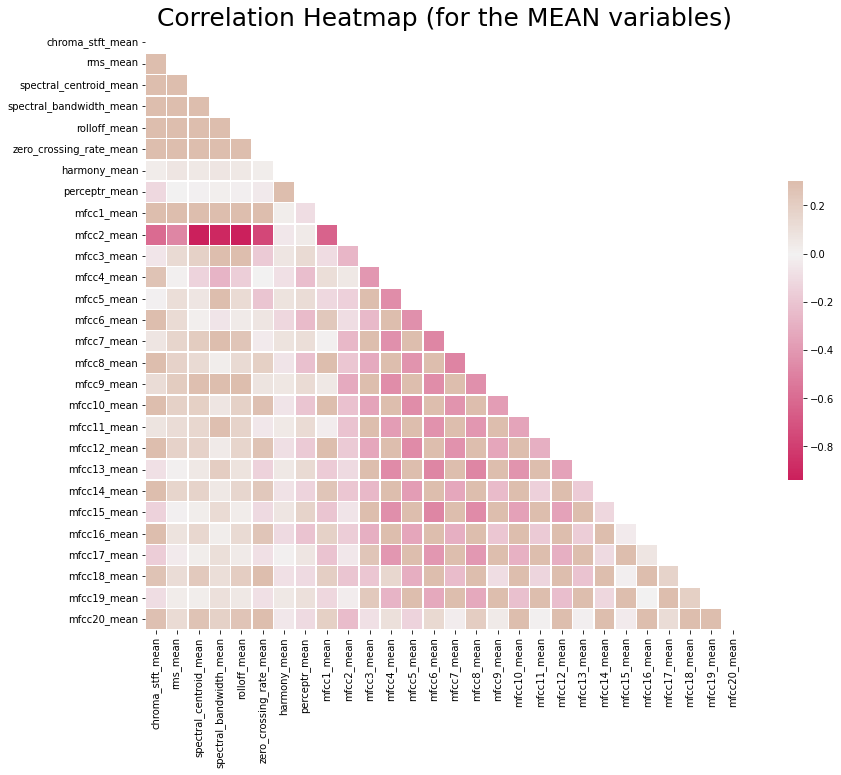

In [ ]:
# Computing the correlation matrix
mean_cols = [col for col in data.columns if 'mean' in col]
corr = data[mean_cols].corr()

# Generate a triangular heatmap
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(16, 11));
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);
plt.savefig("Corr Heatmap.jpg")

# Trying different classificators

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

#### Normalizing data

We must normalize the data before using the non-linear classifier algorithms

In [ ]:
y = data['label']
X = data.loc[:, data.columns != 'label']

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
y_3sec = data3sec['label']
X_3sec = data3sec.loc[:, data3sec.columns != 'label']

cols = X_3sec.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X_3sec)

X_3sec = pd.DataFrame(np_scaled, columns = cols)

X_3sec_train, X_3sec_test, y_3sec_train, y_3sec_test = train_test_split(X_3sec, y_3sec, test_size=0.3, random_state=42)

In [ ]:
def heatmap(matrix):
    sns.heatmap(matrix, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
           yticklabels=["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);


# k-NN **classifier**

### Without cross-validation

#### 30-second audios

Accuracy:  0.59 

              precision    recall  f1-score   support

       blues       0.72      0.37      0.49        35
   classical       0.66      0.95      0.78        20
     country       0.48      0.68      0.56        37
       disco       0.54      0.59      0.56        34
      hiphop       0.65      0.54      0.59        24
        jazz       0.85      0.52      0.64        33
       metal       0.69      0.90      0.78        30
         pop       0.57      0.87      0.69        23
      reggae       0.52      0.45      0.48        29
        rock       0.40      0.29      0.33        35

    accuracy                           0.59       300
   macro avg       0.61      0.61      0.59       300
weighted avg       0.60      0.59      0.58       300



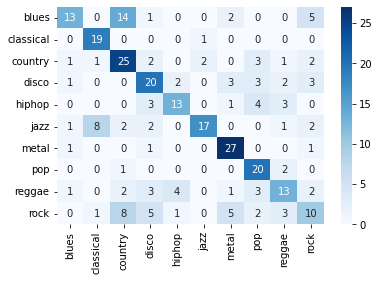

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy: ', round(accuracy_score(y_test, y_pred), 5), '\n')
# print('Precision: ', round(precision_score(y_test, y_pred), 5), '\n')
# print('Recall: ', round(recall_score(y_test, y_pred), 5), '\n')
print(classification_report(y_test, y_pred))
heatmap(confusion_matrix(y_test, y_pred))


#### 3-second audios

Accuracy:  0.80214 

              precision    recall  f1-score   support

       blues       0.85      0.80      0.82       319
   classical       0.86      0.97      0.91       308
     country       0.68      0.79      0.73       286
       disco       0.65      0.83      0.73       301
      hiphop       0.86      0.68      0.76       311
        jazz       0.86      0.80      0.83       286
       metal       0.91      0.83      0.87       303
         pop       0.85      0.87      0.86       267
      reggae       0.78      0.77      0.77       316
        rock       0.81      0.69      0.74       300

    accuracy                           0.80      2997
   macro avg       0.81      0.80      0.80      2997
weighted avg       0.81      0.80      0.80      2997



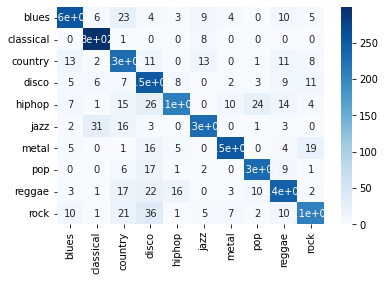

In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_3sec_train, y_3sec_train)
y_3sec_pred = knn.predict(X_3sec_test)

print('Accuracy: ', round(accuracy_score(y_3sec_test, y_3sec_pred), 5), '\n')
# print('Precision: ', round(precision_score(y_test, y_pred), 5), '\n')
# print('Recall: ', round(recall_score(y_test, y_pred), 5), '\n')
print(classification_report(y_3sec_test, y_3sec_pred))
heatmap(confusion_matrix(y_3sec_test, y_3sec_pred))

Baseline kNN shows better results after training on the 3-second features (0.8 > 0.59), as expected

### With cross-validation and hyper-tuning

#### 30-second audios

In [ ]:
knn_cv = KNeighborsClassifier(n_neighbors=20)

cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.57857143 0.65       0.6        0.51428571 0.56428571]
cv_scores mean:0.5814285714285715


 We can see that our mean score is 0.58. Unlike testing on the full train data, this is more accurate representation of future performance on unseen dataset. However, we can try to improve that score using hypertuning of parameters using GridSearchCV.

In [ ]:
knn_ht = KNeighborsClassifier()

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_ht, param_grid, cv=5)

knn_gscv.fit(X_train, y_train)

y_pred = knn_gscv.predict(X_test)
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 5), '\n')

Accuracy:  0.68333 



We can see that with hypertuning the parameters our accuracy is quite a lot better than before. To find out the best suitable for our data number of neighbors we can call best_params_ method.

In [ ]:
print(knn_gscv.best_params_)

{'n_neighbors': 5}


#### 3-second audios

In [ ]:
cv_scores = cross_val_score(knn_cv, X_3sec_train, y_3sec_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_ht, param_grid, cv=5)

knn_gscv.fit(X_3sec_train, y_3sec_train)

y_3sec_pred = knn_gscv.predict(X_3sec_test)
print('Accuracy: ', round(accuracy_score(y_3sec_test, y_3sec_pred), 5), '\n')

[0.7884203  0.768406   0.78984989 0.7739628  0.76108727]
cv_scores mean:0.7763452537629064
Accuracy:  0.92559 



Once again, the accuracy is a lot higher for the 3-second features

# SVM

### Without cross-validation

#### 30-second audios

Accuracy:  0.64333 

              precision    recall  f1-score   support

       blues       0.62      0.46      0.52        35
   classical       0.91      1.00      0.95        20
     country       0.64      0.57      0.60        37
       disco       0.56      0.59      0.57        34
      hiphop       0.68      0.71      0.69        24
        jazz       0.90      0.82      0.86        33
       metal       0.56      0.93      0.70        30
         pop       0.78      0.78      0.78        23
      reggae       0.58      0.52      0.55        29
        rock       0.38      0.31      0.34        35

    accuracy                           0.64       300
   macro avg       0.66      0.67      0.66       300
weighted avg       0.64      0.64      0.64       300



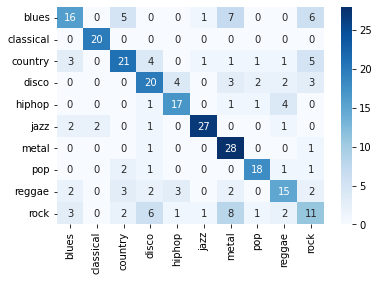

In [ ]:
svm = SVC(decision_function_shape="ovo")
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print('Accuracy: ', round(accuracy_score(y_test, y_pred), 5), '\n')
# print('Precision: ', round(precision_score(y_test, y_pred), 5), '\n')
# print('Recall: ', round(recall_score(y_test, y_pred), 5), '\n')
print(classification_report(y_test, y_pred))
heatmap(confusion_matrix(y_test, y_pred))

#### 3-second audios

Accuracy:  0.75409 

              precision    recall  f1-score   support

       blues       0.75      0.76      0.75       319
   classical       0.87      0.95      0.91       308
     country       0.69      0.67      0.68       286
       disco       0.61      0.66      0.64       301
      hiphop       0.80      0.71      0.75       311
        jazz       0.78      0.82      0.80       286
       metal       0.81      0.89      0.85       303
         pop       0.81      0.87      0.84       267
      reggae       0.75      0.70      0.72       316
        rock       0.63      0.52      0.57       300

    accuracy                           0.75      2997
   macro avg       0.75      0.76      0.75      2997
weighted avg       0.75      0.75      0.75      2997



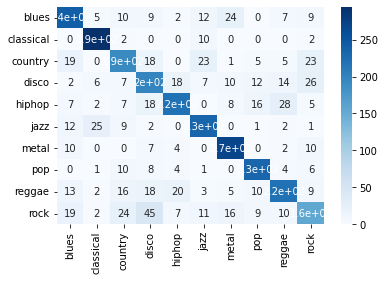

In [ ]:
svm.fit(X_3sec_train, y_3sec_train)
y_3sec_pred = svm.predict(X_3sec_test)

print('Accuracy: ', round(accuracy_score(y_3sec_test, y_3sec_pred), 5), '\n')
# print('Precision: ', round(precision_score(y_test, y_pred), 5), '\n')
# print('Recall: ', round(recall_score(y_test, y_pred), 5), '\n')
print(classification_report(y_3sec_test, y_3sec_pred))
heatmap(confusion_matrix(y_3sec_test, y_3sec_pred))

### With cross-validation and hyper-tuning

#### 30-second audios

In [ ]:
svm_cv = SVC(decision_function_shape="ovo")

cv_scores = cross_val_score(svm_cv, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.63571429 0.71428571 0.72857143 0.62857143 0.67142857]
cv_scores mean:0.6757142857142857


Let's again use hypertuning of parameters.

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

svm_grid = GridSearchCV(SVC(decision_function_shape="ovo"),param_grid,refit=True,verbose=2)
svm_grid.fit(X_train, y_train)
y_pred = svm_grid.predict(X_test)

print('Accuracy: ', round(accuracy_score(y_test, y_pred), 5), '\n')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

In [ ]:
print(svm_grid.best_params_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


#### 3-second audios

In [ ]:
cv_scores = cross_val_score(svm_cv, X_3sec_train, y_3sec_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

svm_grid.fit(X_3sec_train, y_3sec_train)
y_3sec_pred = svm_grid.predict(X_3sec_test)

print('Accuracy: ', round(accuracy_score(y_3sec_test, y_3sec_pred), 5), '\n')

print(svm_grid.best_params_)

[0.71408149 0.7491065  0.71408149 0.73819742 0.72532189]
cv_scores mean:0.7281577583006869
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END .....................C=0.1, 

Both kNN and SVM do a great job and show similar results on both datasets

# CNN

## Data preparation

### Data generation

We tried running the CNN on the spectrograms already present in the dataset(images_original), aka spectrograms for every 30-second snippet, but the results were unsatisfactory

Thus, we moved on to generating 3-second audio files from the given snippets.

It was done locally using following code:

In [ ]:
# based on https://github.com/KunalVaidya99/Music-Genre-Classification

!pip install pydub
from pydub import AudioSegment

genres = 'blues classical country disco pop hiphop metal reggae rock'
genres = genres.split()

for g in genres:
  path1 = os.path.join('./audio3sec',f'{g}')
  os.makedirs(path1)
  path = os.path.join('./spectrograms3sec',f'{g}')
  os.makedirs(path)

for g in genres:
  j=0
  print(f"{g}")
  for filename in os.listdir(os.path.join('./Data/genres_original/',f"{g}")):
    song  =  os.path.join(f'./Data/genres_original/{g}',f'{filename}')
    j = j+1
    for w in range(0,10):
      t1 = 3*(w)*1000
      t2 = 3*(w+1)*1000
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(f'/content/audio3sec/{g}/{g+str(j)+str(w)}.wav', format="wav")

for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('./audio3sec',f"{g}")):
    song  =  os.path.join(f'./audio3sec/{g}',f'{filename}')
    j = j+1
    y,sr = librosa.load(song,duration=3)
    mels = librosa.feature.melspectrogram(y=y,sr=sr)
    fig = plt.Figure()
    canvas = FigureCanvas(fig)
    p = plt.imshow(librosa.power_to_db(mels,ref=np.max))
    plt.savefig(f'./spectrograms3sec/{g}/{g+str(j)}.png')

As this spectrogram generation took quite a lot of time, for now we have generated snippets only for following genres: blues, classical, country, disco, hiphop, metal and pop.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os
import random
!pip install librosa
import librosa
import skimage
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import numpy as np

from keras import layers
from keras.layers import Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.models import Model
from keras.preprocessing import image
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.gradient_descent import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator

### Generating train-test

In [ ]:
genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal']

directory = "/content/drive/MyDrive/spectrograms3sec"
destination = shutil.copytree(directory, "/content/spectrograms3sec_train", copy_function = shutil.copy) 
for g in genres:

  path = os.path.join('/content/spectrograms3sec_test/',f'{g}')
  os. makedirs(path)

for g in genres:
  filenames = os.listdir(os.path.join(destination,f"{g}"))
  random.shuffle(filenames)
  test_files = filenames[0:round(len(filenames)*0.2)]

  for f in test_files:

    shutil.move(destination + "/"+f"{g}"+ "/" + f,"/content/spectrograms3sec_test/" + f"{g}")


### Fitting the model

In [ ]:
train_dir = "/content/spectrograms3sec_train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(256,256),color_mode="rgba",class_mode='categorical',batch_size=128)

validation_dir = "/content/spectrograms3sec_test/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(256,256),color_mode='rgba',class_mode='categorical',batch_size=128)


Found 5609 images belonging to 7 classes.
Found 1408 images belonging to 7 classes.


In [ ]:
def GenreModel(input_shape = (256,256,4),classes=7):
  np.random.seed(7)
  X_input = Input(input_shape)

  X = Conv2D(8,kernel_size=(3,3),strides=(2,2))(X_input)
  X = Activation('relu')(X)
  X = BatchNormalization(axis=3)(X)
  
  X = Conv2D(16,kernel_size=(3,3),strides = (2,2))(X)
  X = Activation('relu')(X)
  X = BatchNormalization(axis=3)(X)

  X = Conv2D(32,kernel_size=(3,3),strides = (2,2))(X)
  X = Activation('relu')(X)
  X = BatchNormalization(axis=3)(X)
  X = MaxPooling2D((2,2))(X)

  X = Flatten()(X)
  X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=7))(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

In [ ]:
import keras.backend as K
#from old keras source code
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model = GenreModel(input_shape=(256,256,4),classes=7)
opt = SGD(learning_rate=0.005)
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy',get_f1])
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 127, 127, 8)       296       
                                                                 
 activation (Activation)     (None, 127, 127, 8)       0         
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 8)      32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 16)        1168      
                                                                 
 activation_1 (Activation)   (None, 63, 63, 16)        0         
                                                        

In [ ]:
model.fit(train_generator,epochs=30,validation_data=vali_generator)

Epoch 1/30
44/44 [==============================] - 124s 3s/step - loss: 15.9718 - accuracy: 0.2541 - get_f1: 0.2530 - val_loss: 1.8056 - val_accuracy: 0.3082 - val_get_f1: 0.0419
Epoch 2/30
44/44 [==============================] - 117s 3s/step - loss: 4.2392 - accuracy: 0.4234 - get_f1: 0.4219 - val_loss: 1.6676 - val_accuracy: 0.3139 - val_get_f1: 0.0167
Epoch 3/30
44/44 [==============================] - 97s 2s/step - loss: 1.6623 - accuracy: 0.5620 - get_f1: 0.5606 - val_loss: 1.5999 - val_accuracy: 0.3224 - val_get_f1: 0.2079
Epoch 4/30
44/44 [==============================] - 98s 2s/step - loss: 1.2224 - accuracy: 0.6326 - get_f1: 0.6281 - val_loss: 1.4072 - val_accuracy: 0.4602 - val_get_f1: 0.2614
Epoch 5/30
44/44 [==============================] - 104s 2s/step - loss: 0.8970 - accuracy: 0.7058 - get_f1: 0.6994 - val_loss: 1.1382 - val_accuracy: 0.5760 - val_get_f1: 0.4143
Epoch 6/30
44/44 [==============================] - 96s 2s/step - loss: 0.7444 - accuracy: 0.7401 - get_f1

# Recent work

## Generating features
As we were trying to fit CNN for better performance we realized that despite our attempts to figure out the best model architecture that is best for our data it perfroms worse than such classifiers as KNN and SVM that we've tried to use before. It is also slower comparred to other models, and considering that we have a pretty big data frame (as we decided to train our model on 3 sec audio snippets for better performance), we decided to focuse on those calssifiers. However when using those we needed to generate features for our audio files, before we used the data with already generated features.

Note: because of the data size this code takes quite a while to run, so it was runned localy. You can find already generated csv file on the google drive folder (the link is in the README of our [repository](https://github.com/monberin/music_genre_classification))

In [ ]:
# generate features from audio files
import librosa
from librosa import feature, onset, beat, effects
import numpy as np
import csv

out_file = "features.csv"
header =[
 "chroma_stft",
 "chroma_cens",
 "spectral_centroid",
 "spectral_bandwidth",
 "spectral_rolloff",
 "poly_features",
 "rmse",
 "zero_crossing_rate",
 "spectral_flatness",
 "spectral_centroids[0]",
 "spectral_centroids_delta",
 "spectral_centroids_accelerate",
 "spectral_bandwidth_2",
 "spectral_bandwidth_3",
 "spectral_bandwidth_4",
 "spectral_flux",
 "tempo_bpm",
 "harmonics",
 "perceptual_shock_wave",
 "mfcc",
 "mfcc_delta",
 "mfcc_acc",
 "genre"
]

fn_list_i = [
 feature.chroma_stft,
 feature.chroma_cens,
 feature.spectral_centroid,
 feature.spectral_bandwidth,
 feature.spectral_rolloff,
 feature.poly_features
]

fn_list_ii = [
 feature.rms,
 feature.zero_crossing_rate,
 feature.spectral_flatness
]
 
def get_feature_vector(y,sr): 
    feat_vect_i = [ np.mean(funct(y,sr)) for funct in fn_list_i]
    feat_vect_ii = [ np.mean(funct(y)) for funct in fn_list_ii] 
    feature_vector = feat_vect_i + feat_vect_ii 
    spectral_centroids = feature.spectral_centroid(y, sr=sr)[0]
    spectral_centroids_delta = np.mean(feature.delta(spectral_centroids))
    spectral_centroids_accelerate = np.mean(feature.delta(spectral_centroids, order=2))
    feature_vector.append(np.mean(spectral_centroids))
    feature_vector.append(spectral_centroids_delta)
    feature_vector.append(spectral_centroids_accelerate)

    # Spectral Bandwidth
    # The spectral bandwidth is defined as the width of the band of light at one-half the peak
    # maximum (or full width at half maximum [FWHM]) and is represented by the two vertical
    # red lines and λSB on the wavelength axis.
    spectral_bandwidth_2 = np.mean(librosa.feature.spectral_bandwidth(y, sr=sr)[0])
    spectral_bandwidth_3 = np.mean(librosa.feature.spectral_bandwidth(y, sr=sr, p=3)[0])
    spectral_bandwidth_4 = np.mean(librosa.feature.spectral_bandwidth(y, sr=sr, p=4)[0])
    feature_vector.append(spectral_bandwidth_2)
    feature_vector.append(spectral_bandwidth_3)
    feature_vector.append(spectral_bandwidth_4)

    # spectral flux
    onset_env = np.mean(onset.onset_strength(y=y, sr=sr))
    feature_vector.append(onset_env)
    
    tempo_y, _ = beat.beat_track(y, sr=sr)
    feature_vector.append(np.mean(tempo_y))

    # Perceptrual shock wave represents the sound rhythm and emotion
    y_harm, y_perc = effects.hpss(y)

    feature_vector.append(np.mean(y_harm))
    feature_vector.append(np.mean(y_perc))

    mfcc_alt = feature.mfcc(y=y, sr=sr)
    delta = np.mean(feature.delta(mfcc_alt))
    accelerate = np.mean(feature.delta(mfcc_alt, order=2))

    feature_vector.append(np.mean(mfcc_alt))
    feature_vector.append(delta)
    feature_vector.append(accelerate)


    return feature_vector

dirname = "audio3sec/audio3sec"
feature_vectors = []

genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal', 'reggae','rock']
for g in genres:
    filenames = os.listdir(os.path.join(dirname+"/",f'{g}'))
    for file in filenames:
        y , sr = librosa.load(dirname+"/"+f'{g}'+"/"+file,sr=None)
        feature_vector = get_feature_vector(y, sr)
        feature_vector.append(g)
        feature_vectors.append(feature_vector) 

print(feature_vectors[2005])

with open(out_file,"+w") as f:
    csv_writer = csv.writer(f, delimiter = ",")
    csv_writer.writerow(header)
    csv_writer.writerows(feature_vectors)

In [ ]:
import csv
data = pd.read_csv('features.csv')
data.head()

,chroma_stft,chroma_cens,spectral_centroid,spectral_bandwidth,spectral_rolloff,poly_features,rmse,zero_crossing_rate,spectral_flatness,spectral_centroids[0],spectral_centroids_delta,spectral_centroids_accelerate,spectral_bandwidth_2,spectral_bandwidth_3,spectral_bandwidth_4,spectral_flux,tempo_bpm,harmonics,perceptual_shock_wave,mfcc,mfcc_delta,mfcc_acc,genre
0,0.229185,0.193394,1228.545992,1866.394513,2363.186223,1.113487,0.174018,0.036392,0.000805,1228.545992,8.205145,-1.527236,1866.394513,2558.653956,3145.933188,1.635290,161.499023,-0.000019,-0.000111,[[-197.3969 -222.55592 -259.0587 ... -...,-0.026567,0.061791,blues
1,0.233627,0.220155,1728.856208,2297.960195,4302.996544,1.133976,0.159065,0.047979,0.001090,1728.856208,2.546529,-1.185939,2297.960195,2867.040370,3352.756207,1.655349,112.347147,0.000074,0.000008,[[-240.53848 -250.07129 -264.12207 ... -...,0.045527,0.047385,blues
2,0.296952,0.249668,1383.999680,2144.163839,3464.858023,0.538993,0.061431,0.037098,0.001604,1383.999680,0.259073,0.906442,2144.163839,2775.873550,3328.952532,1.069259,80.749512,-0.000011,-0.000284,[[-2.36634094e+02 -2.40242889e+02 -2.63652496e...,0.021633,0.005380,blues
3,0.299724,0.233093,1884.155476,2040.293066,3864.050481,0.841077,0.089034,0.090306,0.001506,1884.155476,1.304601,-0.999426,2040.293066,2537.706702,3001.534252,1.369630,215.332031,0.000007,-0.000040,[[-307.85876 -314.22787 -327.47473 .....,-0.022079,0.008306,blues
4,0.333609,0.250243,1626.182539,2066.013583,3631.077787,0.715862,0.068844,0.059056,0.001852,1626.182539,4.562945,1.423614,2066.013583,2609.624720,3112.151502,1.315963,215.332031,0.000004,-0.000110,[[-208.38562 -199.39006 -212.95554 .....,-0.025770,-0.018646,blues


In [ ]:
data.describe()

,chroma_stft,chroma_cens,spectral_centroid,spectral_bandwidth,spectral_rolloff,poly_features,rmse,zero_crossing_rate,spectral_flatness,spectral_centroids[0],spectral_centroids_delta,spectral_centroids_accelerate,spectral_bandwidth_2,spectral_bandwidth_3,spectral_bandwidth_4,spectral_flux,tempo_bpm,harmonics,perceptual_shock_wave,mfcc_delta,mfcc_acc
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,0.388658,0.251005,2245.172874,2266.371907,4658.383782,1.684498,0.135802,0.105532,0.022816,2245.172874,0.119658,-0.608590,2266.371907,2764.126306,3227.329405,1.414744,125.104310,-0.000324,-0.000392,-0.000069,0.005583
std,0.087832,0.026205,740.993492,533.593329,1616.903561,0.937318,0.068691,0.045054,0.032586,740.993492,8.832616,4.143572,533.593329,510.862584,494.932051,0.358792,32.459177,0.001561,0.001147,0.047501,0.022331
min,0.107137,0.144158,490.859642,499.159165,658.336276,0.007788,0.000953,0.013525,0.000031,490.859642,-66.252425,-27.504111,499.159165,573.132549,637.414438,0.402868,24.377211,-0.026672,-0.008794,-0.237445,-0.135037
25%,0.329814,0.236602,1688.228123,1934.327815,3530.989802,1.014949,0.089930,0.070679,0.003487,1688.228123,-4.187877,-2.378148,1934.327815,2434.490638,2887.292000,1.145565,103.359375,-0.000110,-0.000491,-0.026332,-0.006124
50%,0.393332,0.259600,2262.786435,2251.843676,4738.795448,1.594094,0.126725,0.101677,0.011021,2262.786435,0.004897,-0.361205,2251.843676,2691.680562,3103.233691,1.352283,123.046875,-0.000012,-0.000054,-0.001222,0.005769
75%,0.448247,0.271257,2739.723908,2598.064550,5645.219069,2.261022,0.181964,0.135790,0.030916,2739.723908,4.317474,1.310381,2598.064550,3143.820369,3649.033328,1.641291,143.554688,0.000016,0.000022,0.025144,0.017452
max,0.749375,0.285271,5432.375445,3708.166742,9487.529297,5.544438,0.442569,0.320305,0.889801,5432.375445,64.913226,22.341484,3708.166742,4080.503753,4430.932291,2.900754,287.109375,0.015687,0.006816,0.305194,0.124957


In [ ]:
# print(data.dtypes)
y = data['genre']
X = data.loc[:, data.columns != 'genre']
X = X.drop('mfcc', 1)

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Training models
Now, using the generetad features we train two of our classifiers to determine which one performs better. As we've determined from the previous attempts to train models (see in Previous Work) they perform better with cross validation and hyperparameter tuning

### KNN

In [ ]:
knn_ht = KNeighborsClassifier()

cv_scores = cross_val_score(knn_ht, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_ht, param_grid, cv=5)

# np.any(np.isnan(X_train))
# np.all(np.isfinite(X_train))

# np.any(np.isnan(X_test))
# np.all(np.isfinite(X_test))

knn_gscv.fit(X_train, y_train)

y_pred = knn_gscv.predict(X_test)
print('Accuracy: ', round(accuracy_score(y_test, y_pred), 5), '\n')

[0.71587302 0.73412698 0.70634921 0.73809524 0.70634921]
cv_scores mean:0.7201587301587302
Accuracy:  0.75667 



### SVM

In [ ]:
svm_cv = SVC(decision_function_shape="ovo")

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

svm_grid = GridSearchCV(SVC(decision_function_shape="ovo"),param_grid,refit=True,verbose=2)

cv_scores = cross_val_score(svm_cv, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

svm_grid.fit(X_train, y_train)
y_pred = svm_grid.predict(X_test)

print('Accuracy: ', round(accuracy_score(y_test, y_pred), 5), '\n')

print(svm_grid.best_params_)

[0.6515873  0.68015873 0.64761905 0.67301587 0.65714286]
cv_scores mean:0.661904761904762
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.9s
[CV] END .....................C=0.1, g

### Random forest

We've also decided to train random forest classifier for more comparison.

In [ ]:
# trying random forest

y = data['genre']
X = data.loc[:, data.columns != 'genre']
X = X.drop('mfcc', 1)


genres = ['blues', 'classical', 'country', 'disco', 'pop', 'hiphop', 'metal', 'reggae','rock']


for ind in range(len(genres)):
    y = y.replace(genres[ind],ind)

print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(random_state = 42)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf)
CV_rfc.fit(X_train, y_train)
cv_scores = cross_val_score(CV_rfc, X_train, y_train, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))
y_pred = CV_rfc.predict(X_test)

print('Accuracy: ', round(accuracy_score(y_test, y_pred), 5), '\n')

print(CV_rfc.best_params_)


0    0
1    0
2    0
3    0
4    0
Name: genre, dtype: int64


## Conclusions

Based on the results of our training process (too see the comparison look at our presintation in [repository](https://github.com/monberin/music_genre_classification)), we decided to choose SVM as our final model, as it performed the best. It's also relatively fast to train - not as fast as KNN but much faster than Random Forest. We will also use the best determined grid parameters in our work. The next step was to write a simple app to show the work of our model. You can try it out yourself by cloning our repository and running app/gui_app.py. It currently supports such formats of audio files: mp3, wav, flv. Have fun!